**IEM Closure of $f_B$ in 1D**

Following [Pope et al. 1985](https://www.sciencedirect.com/science/article/abs/pii/0360128585900024) the evolution equation for these distributions is given by

\begin{equation}
\frac{\partial f_B}{\partial t} = -\frac{\partial }{\partial b} \left( \mathbb{E}_B[ \alpha \nabla^2 B ] f_B \right).
\end{equation}

As $f_B(b,t)$ contains no information about space this equation is unclosed as the conditional expectation is unknown, however we can apply the IEM closure developed by (Dopazo, C. & O'Brien, E. 1974) and discussed by (Pope, S.B. 2010) to estimate a closure for the molecular mixing terms. This closure takes the form

\begin{equation}
    \mathbb{E}_B[ \alpha \nabla^2 B ] = - \frac{\omega_B}{2}  \left( b - \mathbb{E}[B] \right),
\end{equation}

where $\omega_B$ is the dissipation frequency that must be modelled. Substituting in for this closure we obtain

\begin{equation}
\frac{\partial f_B}{\partial t} =  \frac{\partial }{\partial b} \left( \frac{\omega_B}{2} \left( b - \mathbb{E}[B] \right) f_B \right).
\end{equation}

Integration of this equation with respect to $b$ shows that it conserves $f_B$. As noted by (Fox, R.O. 2003) the IEM closure does not relax to a Gaussian at large times and in particular for an initial condition consisting of two dirac measures at $b = \pm 1$ does not evolve the PDF at all as $\mathbb{E}[B] = 0$ and therefore the system remains at $f_B(b,t=0)$. To rectify this issue to follow (Valiano, L. & Dopazo, C. 1991) by adding a "bounded" noise to the buoyancy yielding 

\begin{equation}
\frac{\partial f_B}{\partial t} =  \frac{\partial }{\partial b} \left( \frac{\omega_B}{2} \left( b - \mathbb{E}[B] \right) f_B \right) + \frac{\Gamma}{2} \frac{\partial^2 f_B}{\partial b^2},
\end{equation}

where $\Gamma$ must be modelled. We implement the mixing of the initial condition $B(\mathbf{x},t=0)$ consisting of blobs of fluid at $b = \pm 1$. Note that as the evolution of $f_B$ depends on what is happening everywhere in the domain the system is both non-linear and non-local. Our choice of closure therefore results in a McKean-Vlasov equation.

**Code implementation**

First we set the parameters define a numerical grid and the boundary conditions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from derivatives import *
from scipy.integrate import trapezoid as trapz
    
# Model parameters
ω_B = 1
Γ   = 0.01

# Boundary conditions
bc_b = 'Neumann'

# Numerical resolution
N_b = 128

# Domain
b = np.linspace(-3, 3, N_b)

Then we write a solver to time-step the Fokker-Planck/McKean-Vlasov equation.

In [2]:
def solver(f, b, T, Δt):

    f_frames = []
    f_frames.append(f)

    D_b = sparse_grad(b)
    L_b = sparse_laplacian(b, bcs=bc_b)

    def solve(f, b, Δt, L_b, D_b):
        E_B = trapz(y=b*f, x=b)
        RHS = D_b@( .5*ω_B*(b - E_B)*f ) + .5*Γ*L_b@f
        return f + Δt*RHS

    # Loop over all time instants
    for n,t in enumerate(T):

        # 0) Plot the system out
        if n%(len(T)//10) == 0:
            print('t = %3.3f , int f db = %3.3f \n' %(t,trapz(y=f,x=b)))
            fig = plt.figure()
            plt.ylabel('$f_B$')
            plt.xlabel('$b$')
            plt.plot(b,f)
            plt.show()

        # 1) Update the mapping
        f = solve(f, b, Δt, L_b, D_b)

        # 2) Grab the system state
        f_frames.append(f)

    return None

In [ ]:
N_T = 10**3
T, Δt = np.linspace(0,10,N_T,retstep=True)

# Initial conditions for f
N = lambda x,μ,σ: (1./np.sqrt(2*np.pi*σ**2) )*np.exp(-.5*((x - μ)/σ)**2)
f = N(x=b,μ=-1,σ=0.1)/2 + N(x=b,μ=1,σ=0.1)/2

# Solve
solver(f, b, T, Δt)

We now consider the same system but with a forcing term $\boldsymbol{D}^{(1)}$ which accounts for the sources/sinks to $f_{B}$ via diffusion at the boundaries making

\begin{equation}
\frac{\partial f_B}{\partial t} = - \frac{\partial }{\partial b} \boldsymbol{D}^{(1)} f_B - \frac{\partial^2 }{\partial b^2} \left( \mathbb{E}_B[ \alpha |\nabla B|^2 ] f_B \right).
\end{equation}

Because we consider control volumes and do not have any explicit dependancy on space, we can model the dissipation term with the IEM closure 

\begin{equation}
    \mathbb{E}_B[ \alpha |\nabla B|^2 ] f_B = -\int \frac{\omega_B}{2}  \left( b - \mathbb{E}[B] \right) f_B \, db + \frac{\Gamma}{2} f_B,
\end{equation}

we obtain

\begin{equation}
\frac{\partial f_B}{\partial t} =  - \frac{\partial }{\partial b} \boldsymbol{D}^{(1)} f_B + \frac{\partial }{\partial b} \left( \frac{\omega_B}{2} \left( b - \mathbb{E}[B] \right) f_B \right) + \frac{\Gamma}{2} \frac{\partial^2 f_B}{\partial b^2},
\end{equation}

where $\omega_B, \Gamma$ must again be modelled. Integrating this equation with respect to $b$ shows that probability density is conserved provided that $f_B(b) \to 0, \, b \to \pm \infty$. Numerically we choose a sufficiently large domain and impose Neumann boundary conditions. Choosing a forcing $\boldsymbol{D}^{(1)}$ which corresponds to a number of plumes with different strengths and different location we test this closure.


In [4]:
def D1_forcing(loc, std, amp, b):

    from forcing import make_f
    f = make_f(loc, std, amp)(b)
    
    D_b = sparse_grad(b)
    L_b = sparse_laplacian(b, bcs=bc_b)

    E_B = trapz(y=b*f, x=b)
    RHS = .5*ω_B*(b - E_B)*f + .5*Γ*D_b@f

    return RHS, f

Then we write a solver to time-step the now forced Fokker-Planck/McKean-Vlasov equation.

In [5]:
def solver_forced(f, b, T, Δt, D1):

    f_frames = []
    f_frames.append(f)

    D_b = sparse_grad(b)
    L_b = sparse_laplacian(b, bcs=bc_b)

    def solve_forced(f, b, Δt, L_b, D_b, D1):
        E_B = trapz(y=b*f, x=b)
        RHS = -D_b@( D1*f ) + D_b@( .5*ω_B*(b - E_B)*f ) + .5*Γ*L_b@f
        return f + Δt*RHS

    # Loop over all time instants
    for n,t in enumerate(T):

        # 0) Plot the system out
        if n%(len(T)//10) == 0:
            print('t = %3.3f , int f db = %3.3f \n' %(t,trapz(y=f,x=b)))
            fig = plt.figure()
            plt.ylabel('$f_B$')
            plt.xlabel('$b$')
            plt.plot(b,f)
            plt.show()

        # 1) Update the mapping
        f = solve_forced(f, b, Δt, L_b, D_b, D1)

        # 2) Grab the system state
        f_frames.append(f)

    return None

We choose a forcing that should generate a bi-modal PDF as plotted below.

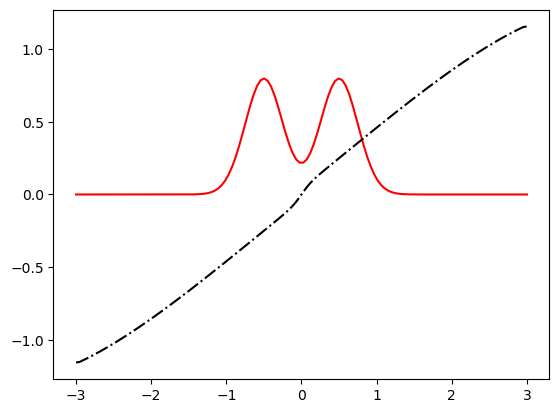

In [6]:
# Location of 'interface(s)'
loc = [-.5, .5]  # Mean/height of the layer
std = [0.25, 0.25]  # Standard deviation of the layer
amp = [1, 1]  # Changes the maximum and minimum buoyancy of the layer

# Enforce normalisation
SUM = np.sum(amp)
amp = [i/SUM for i in amp]

D1f,f = D1_forcing(loc, std, amp, b)
D1 = D1f/f

plt.plot(b,f ,'r-')
plt.plot(b,D1,'k-.')
plt.show()

We then time-step the forced system. As the time-evolution demonstrates the system fails to convergence to the bi-modal PDF.

Why does this happen?

t = 0.000 , int f db = 1.000 



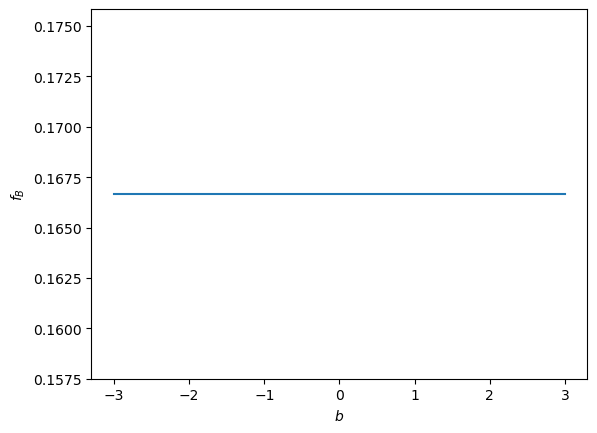

t = 10.001 , int f db = 1.033 



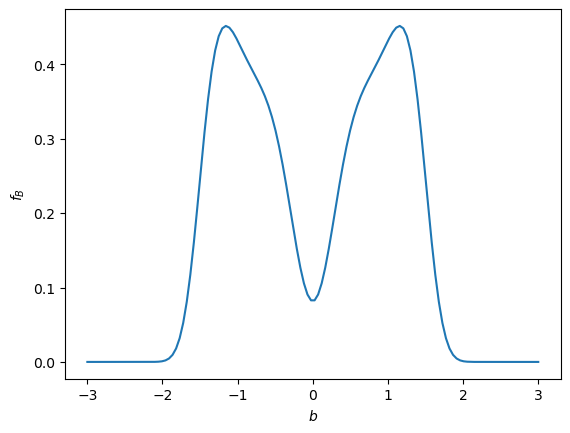

t = 20.002 , int f db = 1.033 



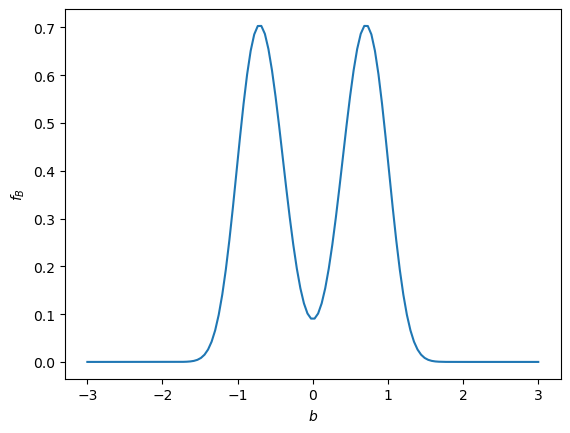

t = 30.003 , int f db = 1.033 



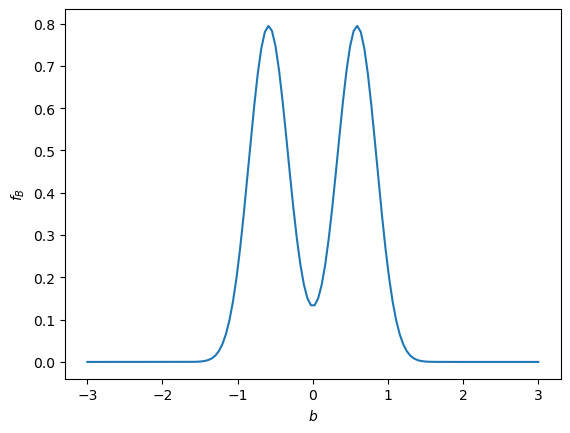

t = 40.004 , int f db = 1.033 



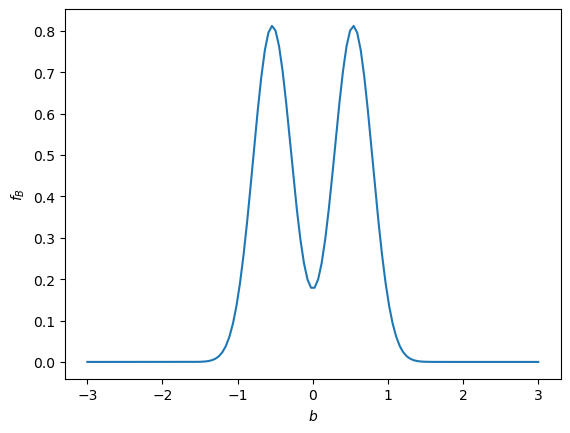

t = 50.005 , int f db = 1.033 



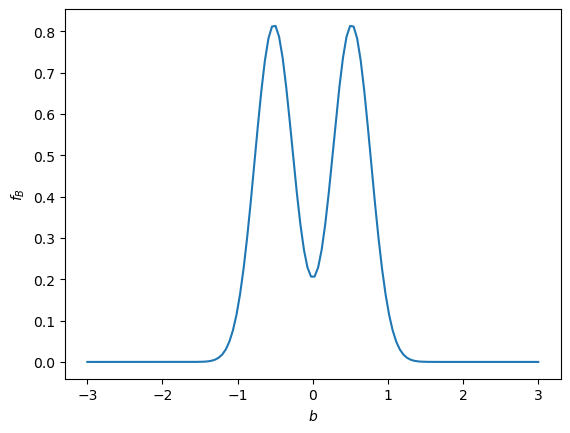

t = 60.006 , int f db = 1.033 



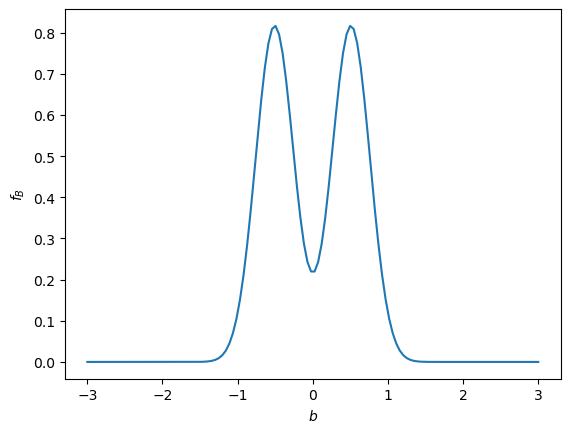

t = 70.007 , int f db = 1.033 



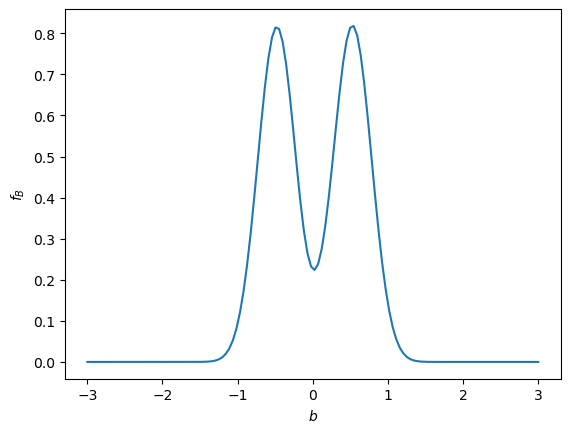

t = 80.008 , int f db = 0.763 



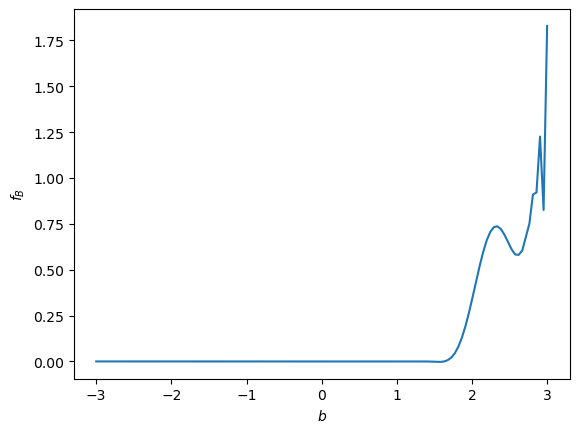

t = 90.009 , int f db = 0.234 



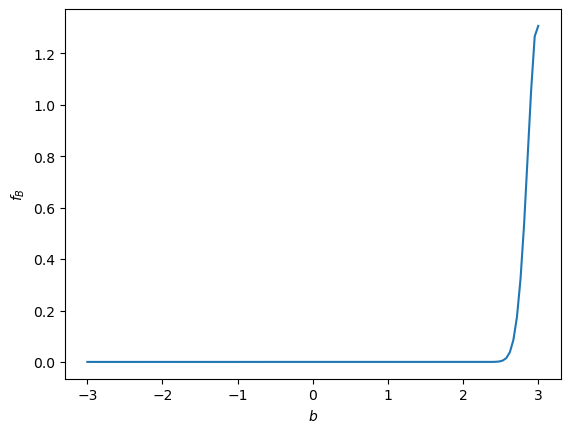

In [7]:
# Time-grid
N_T = 10**4
T, Δt = np.linspace(0,100,N_T,retstep=True)

# Uniform Initial conditions for f
f = np.ones(N_b)/(b[-1] - b[0])

# Solve
solver_forced(f, b, T, Δt, D1)